In [5]:
import pennylane as qml
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import itertools
from varclushi import VarClusHi
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import os
from IPython.display import display, Markdown, Latex
sns.set_style('whitegrid')

In [6]:
# Perform variable clustering
nRowsRead=1000
df1 = pd.read_csv('german_credit_data.csv', delimiter=',', nrows = nRowsRead)

In [7]:
nrow,ncol=df1.shape
nrow,ncol

(1000, 11)

In [8]:
df1.columns

Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

In [9]:
df1.nunique()

Unnamed: 0          1000
Age                   53
Sex                    2
Job                    4
Housing                3
Saving accounts        4
Checking account       3
Credit amount        921
Duration              33
Purpose                8
Risk                   2
dtype: int64

In [10]:
df1.isnull().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [11]:
df1['Saving accounts'].replace(np.nan,'little',inplace=True)


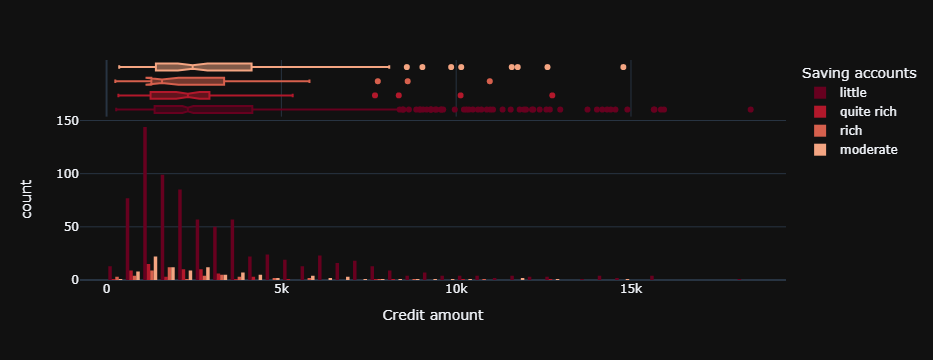

In [12]:
fig = px.histogram(df1,x='Credit amount',color='Saving accounts',template='plotly_dark',marginal='box',color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(barmode='group')

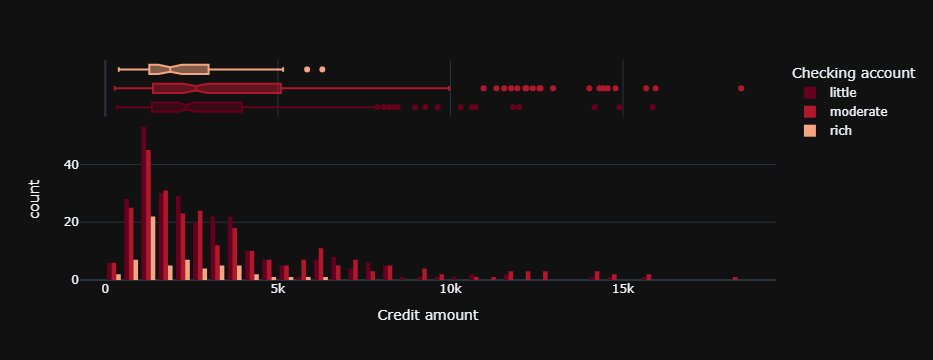

In [13]:
fig = px.histogram(df1,x='Credit amount',color='Checking account',template='plotly_dark',marginal='box',color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(barmode='group')

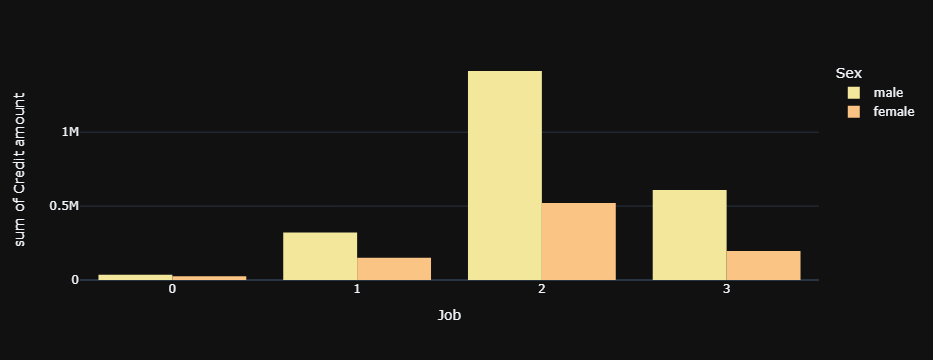

In [14]:
fig = px.histogram(df1,x='Job',y='Credit amount',color='Sex',color_discrete_sequence=px.colors.sequential.Sunset,template='plotly_dark')
fig.update_layout(bargap=0.2,barmode='group')

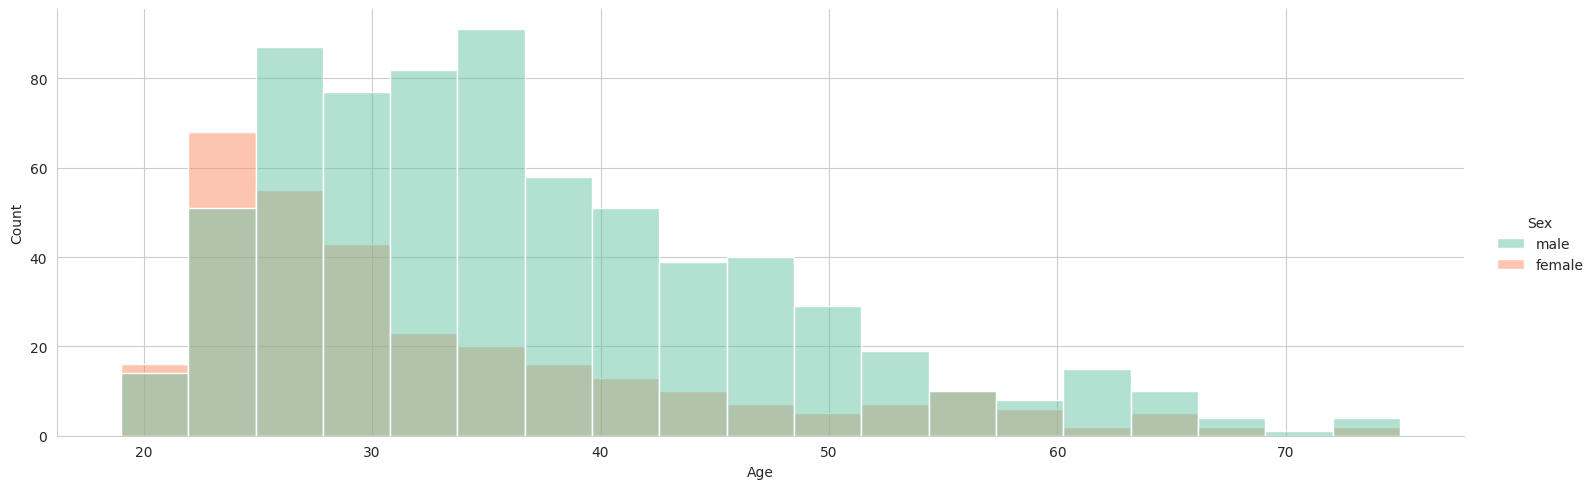

In [15]:
# Age distribution sex-wise
sns.displot(data=df1,x='Age',hue='Sex',kde=False,palette='Set2',aspect=3);

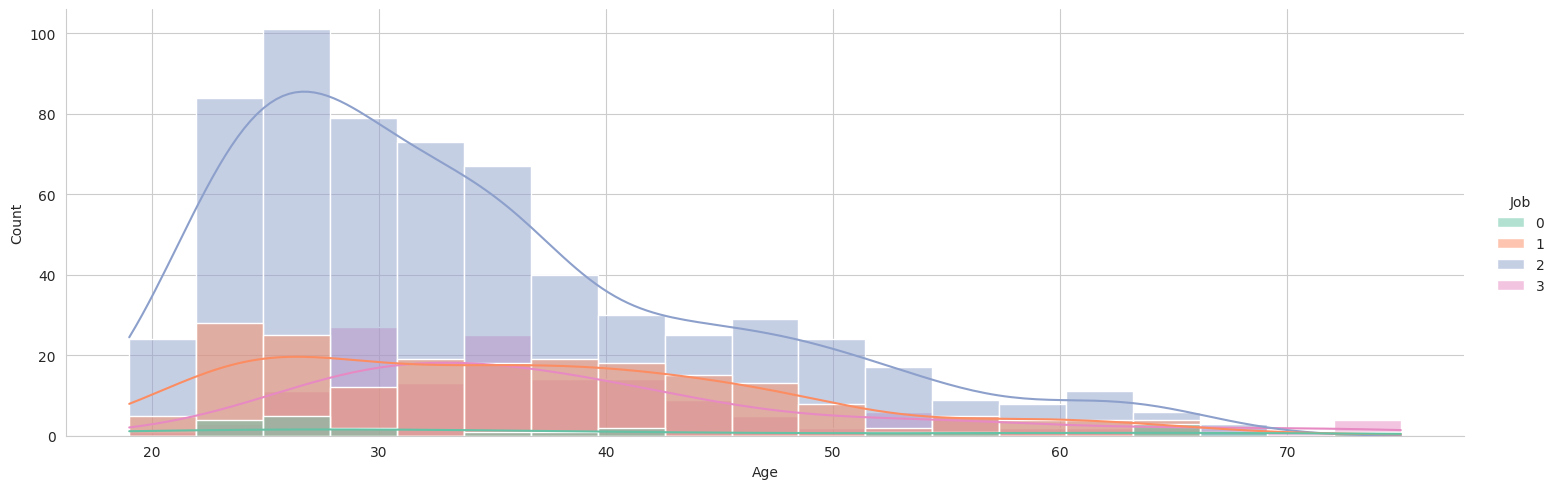

In [16]:
# Age distribution while having different jobs
sns.displot(data=df1,x='Age',hue='Job',kde=True,palette='Set2',aspect=3);

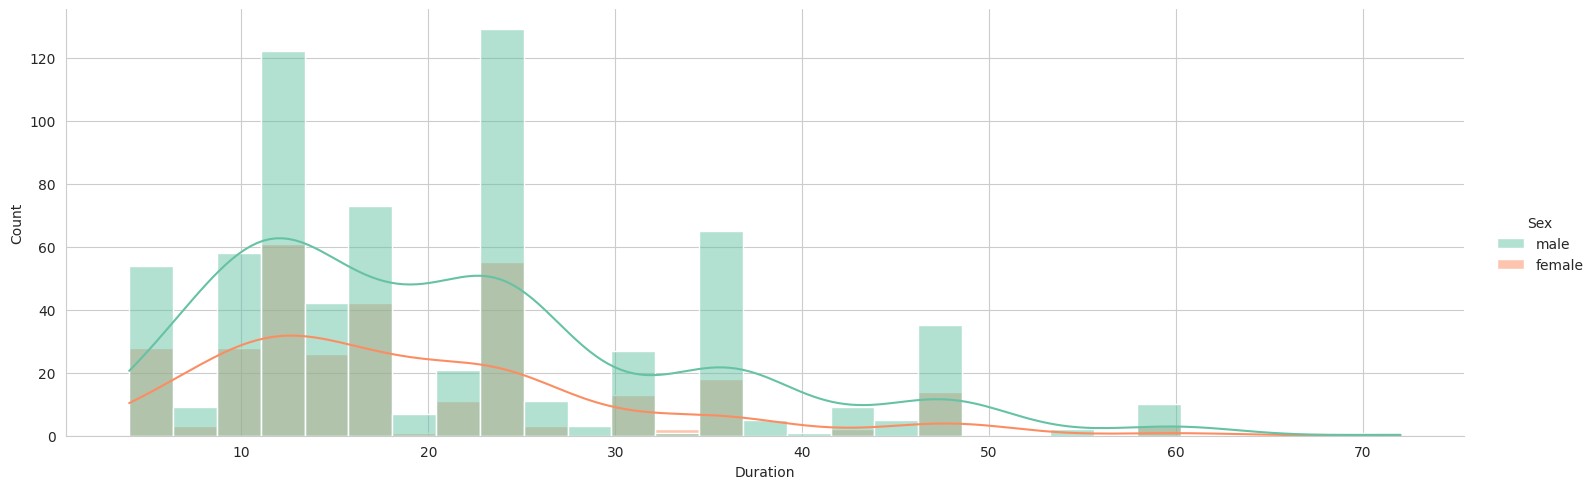

In [17]:
# Duration by Sex
sns.displot(data=df1,x='Duration',hue='Sex',kde=True,palette='Set2',aspect=3);

In [18]:
display(Markdown("#### Explore the Values of Text Columns:"))
cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']
for col in cols:
    line = "**" + col + ":** "
    for v in df1[col].unique():
        line = line + str(v) + ", "
    display(Markdown(line))

#### Explore the Values of Text Columns:

**Sex:** male, female, 

**Housing:** own, free, rent, 

**Saving accounts:** little, quite rich, rich, moderate, 

**Checking account:** little, moderate, nan, rich, 

**Purpose:** radio/TV, education, furniture/equipment, car, business, domestic appliances, repairs, vacation/others, 

**Risk:** good, bad, 

In [19]:
# label encode account quality and fill NaN with 0
def SC_LabelEncoder(text):
    if text == "little":
        return 1
    elif text == "moderate":
        return 2
    elif text == "quite rich":
        return 3
    elif text == "rich":
        return 4
    else:
        return 0

In [20]:
# label encode account quality and fill NaN with 0
def H_LabelEncoder(text):
    if text == "free":
        return 0
    elif text == "rent":
        return 1
    elif text == "own":
        return 2

df1["Housing"] = df1["Housing"].apply(H_LabelEncoder)

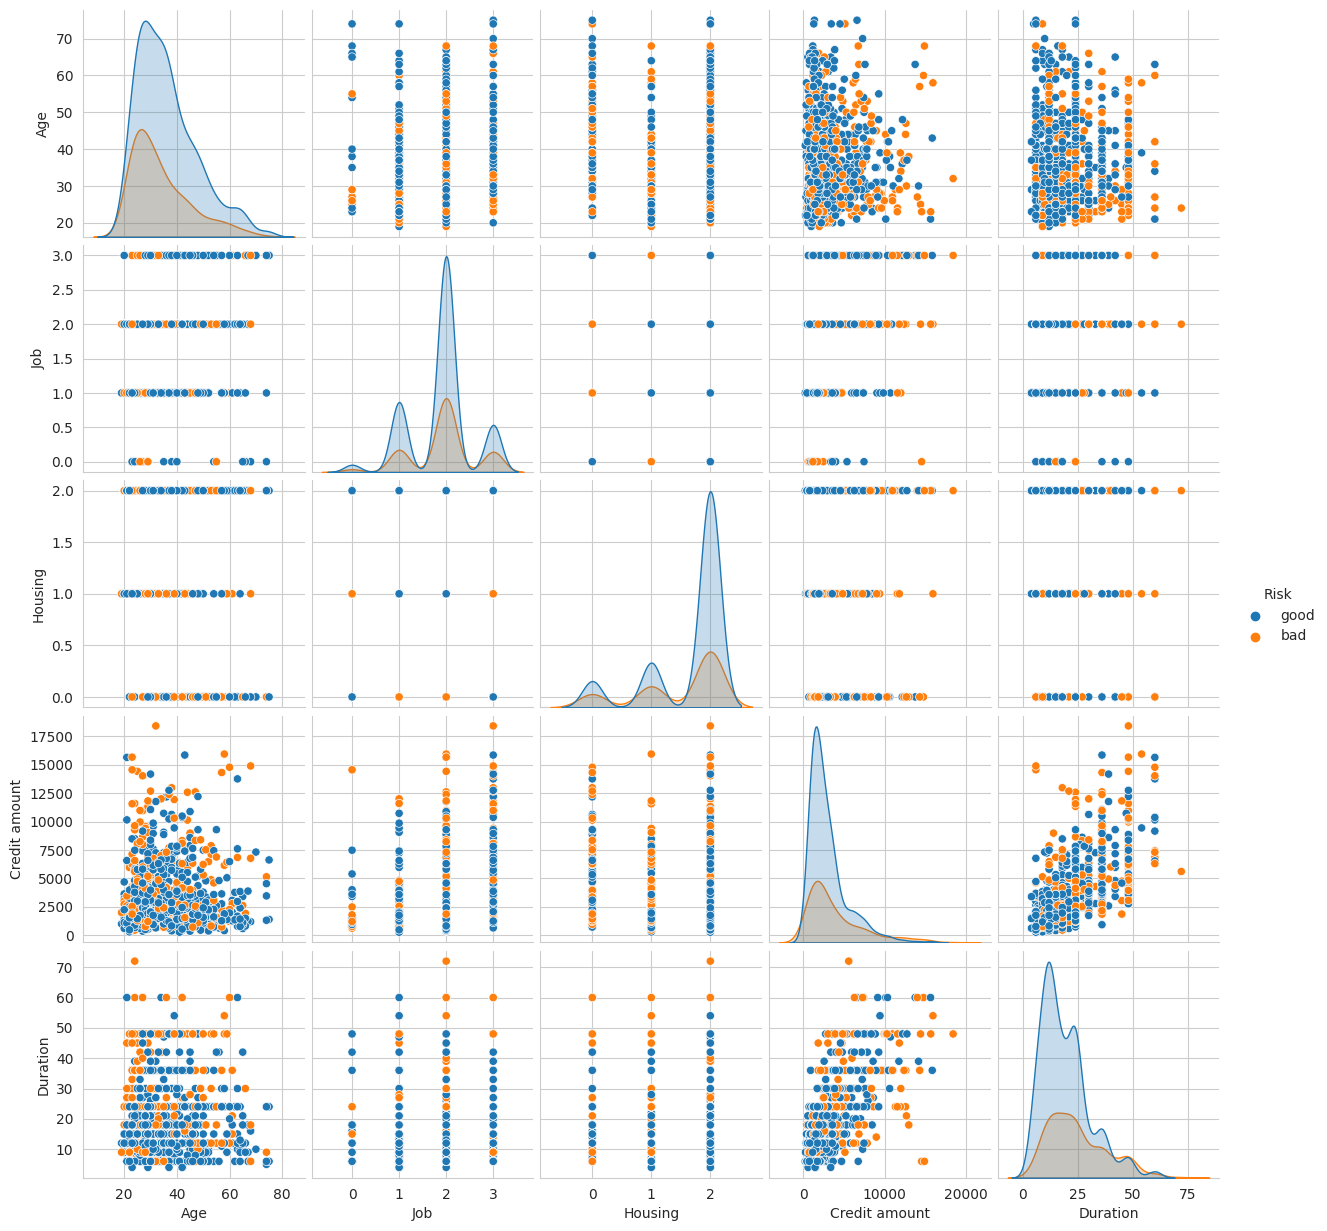

In [21]:
sns.pairplot(df1[['Age', 'Job', 'Housing', 'Saving accounts', 
                 'Checking account', 'Credit amount', 'Duration', "Risk"]], hue="Risk");

/tmp/ipykernel_61/1472446959.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



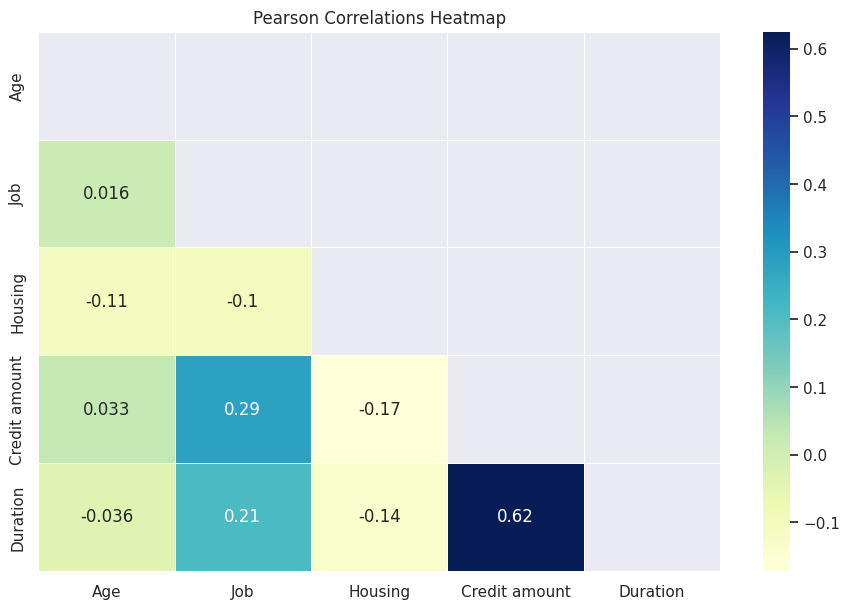

In [22]:
corr = df1[['Age', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration']].corr()
sns.set(rc={'figure.figsize':(11,7)})
sns.heatmap(corr,linewidths=.5, annot=True, cmap="YlGnBu",mask=np.triu(np.ones_like(corr, dtype=bool)))\
    .set_title("Pearson Correlations Heatmap");

In [23]:
# use LabelEncoder() to encode other categorical columns:
for col in ["Sex", "Purpose", "Risk"]:
    le = LabelEncoder()
    le.fit(df1[col])
    df1[col] = le.transform(df1[col])
df1.head()

Unnamed: 0  Age  Sex  Job  Housing Saving accounts Checking account  \
0           0   67    1    2        2          little           little   
1           1   22    0    2        2          little         moderate   
2           2   49    1    1        2          little              NaN   
3           3   45    1    2        0          little           little   
4           4   53    1    2        0          little           little   

   Credit amount  Duration  Purpose  Risk  
0           1169         6        5     1  
1           5951        48        5     0  
2           2096        12        3     1  
3           7882        42        4     1  
4           4870        24        1     0

In [24]:
df1["Saving accounts"] = df1["Saving accounts"].apply(SC_LabelEncoder)
df1["Checking account"] = df1["Checking account"].apply(SC_LabelEncoder)

In [25]:
df1.describe().T

count      mean          std    min      25%     50%  \
Unnamed: 0        1000.0   499.500   288.819436    0.0   249.75   499.5   
Age               1000.0    35.546    11.375469   19.0    27.00    33.0   
Sex               1000.0     0.690     0.462725    0.0     0.00     1.0   
Job               1000.0     1.904     0.653614    0.0     2.00     2.0   
Housing           1000.0     1.605     0.674856    0.0     1.00     2.0   
Saving accounts   1000.0     1.373     0.805307    1.0     1.00     1.0   
Checking account  1000.0     1.064     1.107760    0.0     0.00     1.0   
Credit amount     1000.0  3271.258  2822.736876  250.0  1365.50  2319.5   
Duration          1000.0    20.903    12.058814    4.0    12.00    18.0   
Purpose           1000.0     2.878     1.978138    0.0     1.00     3.0   
Risk              1000.0     0.700     0.458487    0.0     0.00     1.0   

                      75%      max  
Unnamed: 0         749.25    999.0  
Age                 42.00     75.0  
Sex                  1.00      1.0  
Job                  2.00      3.0  
Housing              2.00      2.0  
Saving accounts      1.00      4.0  
Checking account     2.00      4.0  
Credit amount     3972.25  18424.0  
Duration            24.00     72.0  
Purpose              5.00      7.0  
Risk                 1.00      1.0

In [27]:
# Perform variable clustering
Features=['Age', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration']
data= pd.DataFrame(df1, columns=Features)
vc = VarClusHi(data)
vc.varclus()

In [28]:
X = df1[['Age', 'Sex', 'Job', 'Housing', 'Saving accounts','Checking account', 'Credit amount', 'Duration', 'Purpose']]
y = df1['Risk']


In [29]:
vc.rsquare

Cluster          Variable    RS_Own     RS_NC  RS_Ratio
0        0               Job  0.289325  0.000617  0.711113
1        0     Credit amount  0.742128  0.000772  0.258072
2        0          Duration  0.681846  0.002475  0.318943
3        0           Housing  0.137926  0.000054  0.862120
4        1               Age  0.248583  0.000683  0.751931
5        1   Saving accounts  0.355859  0.005241  0.647534
6        1  Checking account  0.460936  0.000009  0.539068

In [30]:
vc = VarClusHi(data,maxeigval2=0,maxclus=3)
vc.varclus()
vc.info

Cluster N_Vars   Eigval1   Eigval2   VarProp
0       0      4  1.851226  0.932499  0.462806
1       1      2  1.045862  0.954138  0.522931
2       2      1  1.000000  0.000000  1.000000

In [31]:
vc_data=vc.rsquare
vc_data.head()

Cluster         Variable    RS_Own     RS_NC  RS_Ratio
0        0              Job  0.289325  0.000259  0.710859
1        0    Credit amount  0.742128  0.002841  0.258607
2        0         Duration  0.681846  0.001541  0.318645
3        0          Housing  0.137926  0.012555  0.873035
4        1  Saving accounts  0.522931  0.005241  0.479582

In [32]:
# Generate unique combinations of variables representing 1 variable per cluster
variable_combinations = list(itertools.product(*[group['Variable'].values for _, group in vc_data.groupby('Cluster')]))
variable_combinations

[('Job', 'Saving accounts', 'Age'),
 ('Job', 'Checking account', 'Age'),
 ('Credit amount', 'Saving accounts', 'Age'),
 ('Credit amount', 'Checking account', 'Age'),
 ('Duration', 'Saving accounts', 'Age'),
 ('Duration', 'Checking account', 'Age'),
 ('Housing', 'Saving accounts', 'Age'),
 ('Housing', 'Checking account', 'Age')]

In [40]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [41]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [42]:
# Define the sample weights
sample_weights = np.ones(len(X_train))


In [43]:
# Define the quantum device
dev = qml.device("default.qubit", wires=13)

# Define the quantum circuit
@qml.qnode(dev)
def quantum_circuit(params, x):
    qml.templates.AngleEmbedding(x, wires=range(13))
    qml.templates.BasicEntanglerLayers(params, wires=range(13))
    return qml.expval(qml.PauliZ(0))

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define the weighted cost function
def weighted_cost(params, X, Y, weights):
    predictions = np.array([sigmoid(quantum_circuit(params, x)) for x in X], dtype=float)
    return -np.sum(weights * (Y * np.log(predictions) + (1 - Y) * np.log(1 - predictions))) / len(Y)


In [53]:
def run_qml_model(combination, train_data, test_data):
    X_train, y_train, X_test, y_test = train_data
    params = np.random.randn(3, 13)  # Update the parameter shape
    opt = qml.GradientDescentOptimizer(stepsize=0.5)

    # Train the model
    for _ in range(n_steps):
        params = opt.step(lambda p: weighted_cost(p, X_train, y_train, sample_weights), params)

    # Make predictions on test data
    predictions = [int(sigmoid(quantum_circuit(params, x)) > 0.5) for x in X_test]
    accuracy = accuracy_score(y_test, predictions)
    return (combination, accuracy)

In [54]:
n_steps = 100  # Set the number of training steps

# Prepare the train and test data
train_data = (X_train, y_train, X_test, y_test)
test_data = (X_test, y_test)
combination=variable_combinations[0]

In [ ]:
mcombi, maccuracy = run_qml_model(combination, train_data, test_data)

In [ ]:
# Run the quantum logistic regression for all combinations in parallel using joblib
results = Parallel(n_jobs=-1)(delayed(run_qml_model)(combination, train_data, test_data) for combination in variable_combinations)


# Sort the results by accuracy and select the top 3 models
top_3_models = sorted(results, key=lambda x: x[1], reverse=True)[:3]
print("\nTop 3 models:")
for model, accuracy in top_3_models:
    print(f"Combination: {model}, Accuracy: {accuracy}")